# Combine u and v wind files

In [1]:
# Libraries
%load_ext autoreload
%autoreload


import numpy as np
import iris
import iris.coord_categorisation
from iris.util import unify_time_units
from iris.experimental.equalise_cubes import equalise_attributes
import iris.quickplot as qplt
# import pandas as pd

import glob
import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

/home/meganbrown/miniconda3/envs/uvis_env/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### Extracting files
Set year range of interest. Note the v and u files must be in the same directory. If you want all files in the directory, use the code commented out (it's much faster!).

In [4]:
path     = '../data/aus_wind/'
path_out = '../data/aus_wind/'
outfile = 'swnd.10m.gauss.'

# Chooses year range you want
years = range(2001, 2010)
u_files = []
v_files = []
for year in years:
    u_files.append(path + 'uwnd.10m.gauss.' + str(year) + '.nc')
    v_files.append(path + 'vwnd.10m.gauss.' + str(year) + '.nc')


### For all u and v files
# u_files = glob.glob(path + 'u*.nc') # use 'recursive = True' to include subdirectories
# u_files = sorted(u_files) # sort alphabetically
# v_files = glob.glob(path + 'v*.nc') 

# Checking file names
print(u_files[0] + v_files[0])

['../data/aus_wind/uwnd.10m.gauss.2001.nc', '../data/aus_wind/uwnd.10m.gauss.2002.nc', '../data/aus_wind/uwnd.10m.gauss.2003.nc', '../data/aus_wind/uwnd.10m.gauss.2004.nc', '../data/aus_wind/uwnd.10m.gauss.2005.nc', '../data/aus_wind/uwnd.10m.gauss.2006.nc', '../data/aus_wind/uwnd.10m.gauss.2007.nc', '../data/aus_wind/uwnd.10m.gauss.2008.nc', '../data/aus_wind/uwnd.10m.gauss.2009.nc']


In [20]:
# For regridding
path_mask = '../data/land_use/'
file_mask = 'pasture2001-2019.nc'

mask1 = iris.load_cube(path_mask + file_mask)
mask = mask.collapsed('time', iris.analysis.MEAN)

### Load in u and v files into separate cubelists

In [16]:
# Load u files
uList = []
for i in u_files[0:3]:
    df = iris.load_cube(i)
#     print(df.coord('time').units)
#     print(df.coord('time').points)
    uList.append(df)

print(uList)
u_cube_list = iris.cube.CubeList(uList)

# # Load v files
# vList = []
# for i in v_files[0:2]:
#     print(i)
#     df = iris.load_cube(i)
#     vList.append(df)



[<iris 'Cube' of 4xDaily u-wind at 10 m / (m/s) (time: 1460; latitude: 94; longitude: 192)>, <iris 'Cube' of 4xDaily u-wind at 10 m / (m/s) (time: 1460; latitude: 94; longitude: 192)>, <iris 'Cube' of 4xDaily u-wind at 10 m / (m/s) (time: 1460; latitude: 94; longitude: 192)>]


In [21]:
dat1_regrid = u_cube_list[1].regrid(mask, iris.analysis.AreaWeighted())

ValueError: The horizontal grid coordinates of both the source and grid cubes must have contiguous bounds.

### Plot out to see it's working

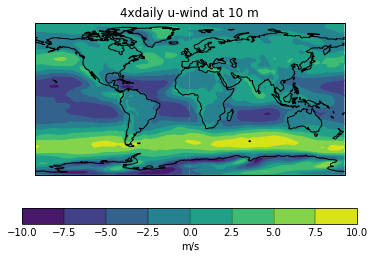

In [24]:
dat1 = u_cube_list[0].collapsed('time', iris.analysis.MEAN)
# dat2 = v_cube_list[0].collapsed('time', iris.analysis.MEAN)
# plot_lonely_cube(dat1, cmap = 'gist_heat_r')
# print(dat1.coord('latitude'))

qplt.contourf(dat1)
plt.gca().coastlines()

### Testing to try and combine cubes together

In [73]:
# unify_time_units(u_cube_list)
equalise_attributes(u_cube_list)
# u = u_cube_list.concatenate_cube()

# v_cube_list = iris.cube.CubeList(vList)
# v = v_cube_list.merge_cube()

print(u)
print(u[0].coord('time').units, u[0].attributes)
print(u[1].coord('time').units, u[1].attributes)
# print(u[2].coord('time').units, u[2].attributes)

0: 4xDaily u-wind at 10 m / (m/s)      (time: 1460; latitude: 94; longitude: 192)
1: 4xDaily u-wind at 10 m / (m/s)      (time: 1460; latitude: 94; longitude: 192)
2: 4xDaily u-wind at 10 m / (m/s)      (time: 1460; latitude: 94; longitude: 192)
hours since 1800-01-01 00:00:0.0 {'Conventions': 'COARDS', 'description': 'Data is from NMC initialized reanalysis\n(4x/day).  It consists of T62 variables interpolated to\npressure surfaces from model (sigma) surfaces.', 'platform': 'Model', 'References': 'http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html', 'dataset_title': 'NCEP-NCAR Reanalysis 1', 'GRIB_id': 33, 'GRIB_name': 'U GRD', 'dataset': 'NCEP Reanalysis', 'least_significant_digit': 1, 'level_desc': '10 m', 'parent_stat': 'Other', 'precision': 2, 'statistic': 'Individual Obs', 'valid_range': array([-102.2,  102.2], dtype=float32), 'var_desc': 'u-wind'}
hours since 1800-01-01 00:00:0.0 {'Conventions': 'COARDS', 'description': 'Data is from NMC initialized reanalysis\n

## Calculate wind speed

For a single year, calculate `s` which is wind speed, given by:

$s = \sqrt(u^2 + v^2)$

In [4]:
u = iris.load_cube(u_files[0])
v = iris.load_cube(v_files[0])

# Have to load in data to do this (may take a while)
v_dat = v.data
u_dat = u.data
s_dat = np.sqrt((v_dat * v_dat) + (u_dat * u_dat))

# Put data in a cube, bit cheating but it works
s = v.copy()
s.data = s_dat

#### Take the 4 measurements per day and find the maximum wind speed. Add day time coordinate

In [5]:
# add_month, add_day_of_year, year
iris.coord_categorisation.add_month(s, 'time', name='month')
iris.coord_categorisation.add_day_of_year(s, 'time', name='day_of_year')
iris.coord_categorisation.add_year(s, 'time', name='year')

In [15]:
test = s.aggregated_by(['day_of_year'], iris.analysis.MAX)
swnd = test.aggregated_by(['month'], iris.analysis.MEAN) # test.aggregated_by(['month', 'year'], iris.analysis.MEAN)

DimCoord(array([1762305., 1763013., 1763721., 1764453., 1765185., 1765917.,
       1766649., 1767393., 1768125., 1768857., 1769589., 1770321.]), bounds=array([[1761936., 1762674.],
       [1762680., 1763346.],
       [1763352., 1764090.],
       [1764096., 1764810.],
       [1764816., 1765554.],
       [1765560., 1766274.],
       [1766280., 1767018.],
       [1767024., 1767762.],
       [1767768., 1768482.],
       [1768488., 1769226.],
       [1769232., 1769946.],
       [1769952., 1770690.]]), standard_name='time', units=Unit('hours since 1800-01-01 00:00:0.0', calendar='gregorian'), long_name='Time', var_name='time', attributes={'actual_range': array([1761936., 1770690.]), 'delta_t': '0000-00-00 06:00:00'})

### Save outputs

In [94]:
out = path_out + outfile + str(years[0]) + '-' + str(years[len(years) -1]) + '.nc'
print(out)
# iris.save(swnd, out)

../data/aus_wind/swnd.10m.gauss.2001-2009.nc
